Import required librairies

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model

Access to the dataset directory:

In [4]:

!ls
os.getcwd()


drive  sample_data


'/content'

dataset cleaning

onfiguration of image sze, training and validation size ( to be considered)

In [2]:
image_size = (200, 200)
batch_size = 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fourclasses",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fourclasses",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1871 files belonging to 2 classes.
Using 1497 files for training.
Found 1871 files belonging to 2 classes.
Using 374 files for validation.


Data augmentation

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.8),
    ]
)

In [4]:
input_shape=(200,200,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

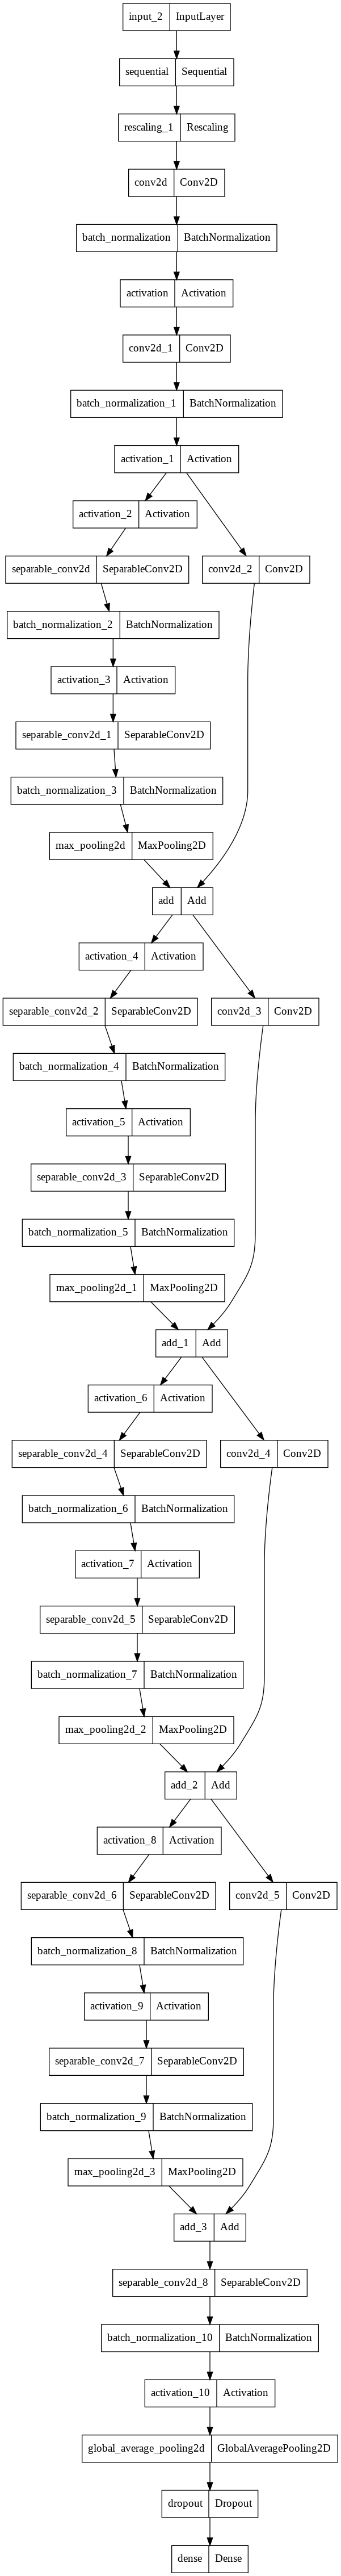

In [6]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=False)

In [ ]:
epochs=20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
model.save("permanent_past", save_format="h5")

Epoch 1/20
47/47 [==============================] - 608s 11s/step - loss: 0.2324 - accuracy: 0.9252 - val_loss: 0.5006 - val_accuracy: 0.9171
Epoch 2/20
47/47 [==============================] - 547s 11s/step - loss: 0.1577 - accuracy: 0.9299 - val_loss: 0.4494 - val_accuracy: 0.9171
Epoch 3/20
47/47 [==============================] - 551s 11s/step - loss: 0.1372 - accuracy: 0.9385 - val_loss: 0.3816 - val_accuracy: 0.9171
Epoch 4/20
47/47 [==============================] - 563s 12s/step - loss: 0.1194 - accuracy: 0.9466 - val_loss: 0.2679 - val_accuracy: 0.9171
Epoch 5/20
47/47 [==============================] - 572s 12s/step - loss: 0.1326 - accuracy: 0.9412 - val_loss: 0.3009 - val_accuracy: 0.9171
Epoch 6/20
47/47 [==============================] - 572s 12s/step - loss: 0.1094 - accuracy: 0.9519 - val_loss: 0.2312 - val_accuracy: 0.9171
Epoch 7/20
47/47 [==============================] - 572s 12s/step - loss: 0.1087 - accuracy: 0.9499 - val_loss: 0.2113 - val_accuracy: 0.9171
Epoch 

In [28]:

new_model = load_model('/content/testmodel_rushes_or_scrub')
image_size= (200, 200)
new_model.summary


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f9af7735110>>

In [30]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/test/test3.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent bare rushes_or_scrub and %.2f percent other."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 114ms/step
This image is 93.61 percent bare rushes_or_scrub and 6.39 percent other.


In [ ]:
from numpy.ma.core import size


plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
     

Data Augmentation

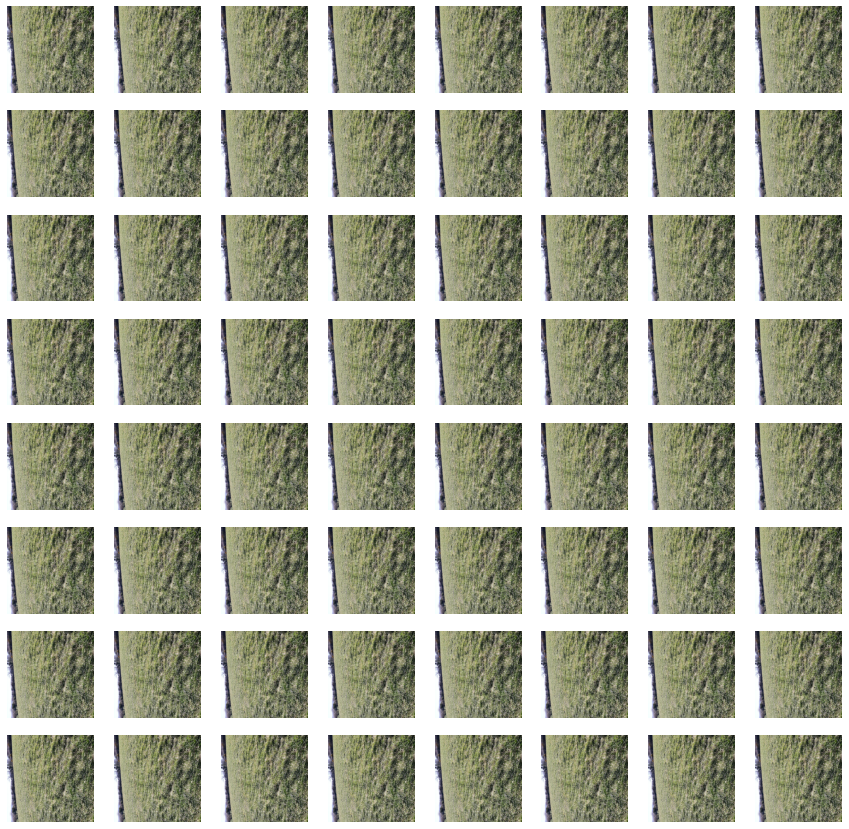

In [ ]:
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
    for i in range(64):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

nput configuration of the model, augmented data used only for training

Building CNN model with dropout

Training and accuracy testing

In [ ]:


num_skipped = 0
for folder_name in ("class1", "class2"):
    folder_path = os.path.join("C:\Users\Admin\Desktop\Niva\Clean Permanent Pasture\Clean Permanent Pasture", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

SyntaxError: ignored

# New Section

# New Section

# New Section